In [ ]:
import os
import random
import shutil
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# для колаба
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Путь для сохранения результата
DIR = 'gdrive/MyDrive/'
# если локально
# DIR = ''

# подгрузим данные
# напомню, что identity_CelebA_mini.csv содержит данные по 200 наиболее часто встречающимся классам
filtered_identity_csv = f"{DIR}identity_CelebA_mini.csv"
filtered_identity_df = pd.read_csv(filtered_identity_csv)
filtered_identity_df

,image_id,id
0,000001.jpg,2880
1,000096.jpg,4262
2,000116.jpg,4887
3,000150.jpg,6568
4,000404.jpg,2880
...,...,...
6033,200678.jpg,9256
6034,200853.jpg,9256
6035,201865.jpg,9256
6036,201873.jpg,9256


In [ ]:
import seaborn as sns

# метод для показа распределения по классам
def show_distribution(df):
    value_counts = df['id'].value_counts()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis").set_xticklabels(value_counts.index, rotation=90)
    plt.xlabel("Класс")
    plt.ylabel("Количество")
    plt.title("Распределение классов")
    plt.show()

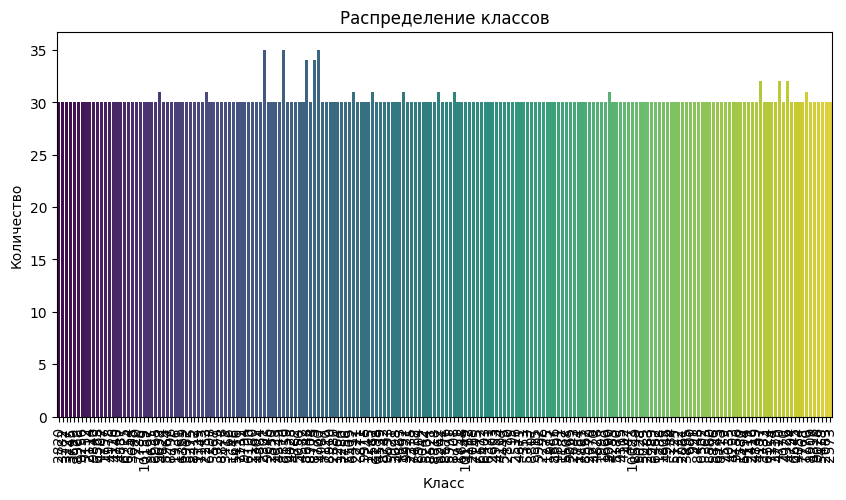

In [ ]:
# посмотрим на распределение по классам
show_distribution(filtered_identity_df)
# видно, что данные распределены довольно равномерно

In [ ]:
import os
from sklearn.model_selection import train_test_split
import shutil

# разобьем данные на train/val/test. Чтобы в каждое разбиение попали все классы, использую stratify
train_val_identity_df, test_identity_df = train_test_split(filtered_identity_df, test_size=0.1, stratify=filtered_identity_df['id'], random_state=42)
train_identity_df, val_identity_df = train_test_split(train_val_identity_df, test_size=0.1, stratify=train_val_identity_df['id'], random_state=42)

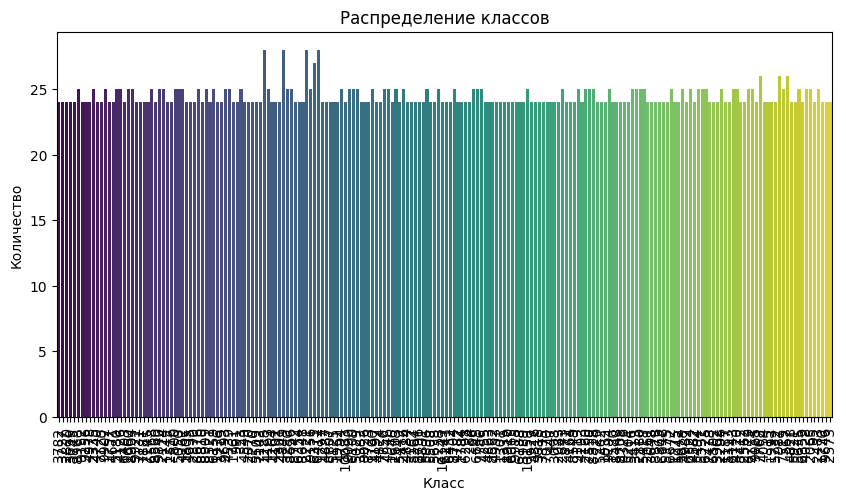

In [ ]:
show_distribution(train_identity_df)

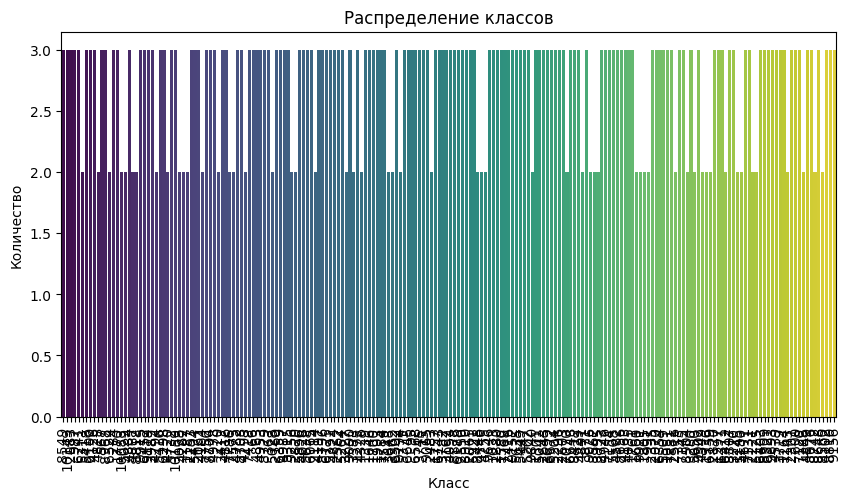

In [ ]:
show_distribution(val_identity_df)

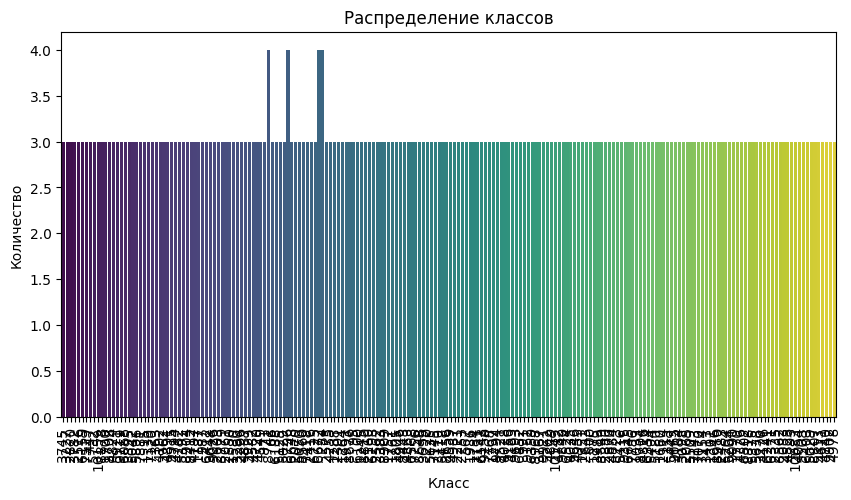

In [ ]:
show_distribution(test_identity_df)

In [ ]:
# убедимся что кол-во классов одинаково
len(train_identity_df['id'].unique()), len(test_identity_df['id'].unique()), len(val_identity_df['id'].unique())

(200, 200, 200)

In [ ]:
train_identity_df.shape, val_identity_df.shape, test_identity_df.shape

((4890, 2), (544, 2), (604, 2))

In [ ]:
# напомню, что aligned_images.zip - это картинки, обработанные и выровненные с помощью Stacked_Hourglass_Network в шаге 1
!unzip -q /content/gdrive/MyDrive/aligned_images.zip

In [ ]:
# в classification_data будут лежать данные из aligned_images, разделенные для train/test/val
os.makedirs('classification_data/train', exist_ok=True)
os.makedirs('classification_data/val', exist_ok=True)
os.makedirs('classification_data/test', exist_ok=True)

In [ ]:
# функция для перемещения файлов
def move_files(df, source_dir, dest_dir):
    for _, row in df.iterrows():
        src = os.path.join(source_dir, row['image_id'])
        dest = os.path.join(dest_dir, row['image_id'])
        shutil.copy(src, dest)

move_files(train_identity_df, 'aligned_images', 'classification_data/train')
move_files(val_identity_df, 'aligned_images', 'classification_data/val')
move_files(test_identity_df, 'aligned_images', 'classification_data/test')

In [ ]:
# torch может работать только с упорядоченными числовыми классами, поэтому преобразую 200 классов в числа от 0 до 200
unique_labels = np.unique(train_identity_df["id"])
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

In [ ]:
label_to_index

{np.int64(15): 0,
 np.int64(66): 1,
 np.int64(95): 2,
 np.int64(220): 3,
 np.int64(284): 4,
 np.int64(353): 5,
 np.int64(363): 6,
 np.int64(447): 7,
 np.int64(567): 8,
 np.int64(600): 9,
 np.int64(871): 10,
 np.int64(987): 11,
 np.int64(991): 12,
 np.int64(1033): 13,
 np.int64(1187): 14,
 np.int64(1245): 15,
 np.int64(1264): 16,
 np.int64(1275): 17,
 np.int64(1288): 18,
 np.int64(1297): 19,
 np.int64(1301): 20,
 np.int64(1339): 21,
 np.int64(1580): 22,
 np.int64(1646): 23,
 np.int64(1660): 24,
 np.int64(1700): 25,
 np.int64(1757): 26,
 np.int64(1761): 27,
 np.int64(1770): 28,
 np.int64(1784): 29,
 np.int64(1805): 30,
 np.int64(1936): 31,
 np.int64(1951): 32,
 np.int64(1993): 33,
 np.int64(2061): 34,
 np.int64(2065): 35,
 np.int64(2070): 36,
 np.int64(2083): 37,
 np.int64(2114): 38,
 np.int64(2160): 39,
 np.int64(2221): 40,
 np.int64(2253): 41,
 np.int64(2296): 42,
 np.int64(2301): 43,
 np.int64(2335): 44,
 np.int64(2416): 45,
 np.int64(2483): 46,
 np.int64(2516): 47,
 np.int64(2550): 4

In [ ]:
# добавляю новую колонку с преобразованным классом
train_identity_df["transformed_labels"] = train_identity_df["id"].map(label_to_index)
val_identity_df["transformed_labels"] = val_identity_df["id"].map(label_to_index)
test_identity_df["transformed_labels"] = test_identity_df["id"].map(label_to_index)
train_identity_df

,image_id,id,transformed_labels
3846,106766.jpg,8562,164
1326,038882.jpg,4953,101
3400,094261.jpg,1301,20
5709,158165.jpg,66,1
5280,146385.jpg,6645,143
...,...,...,...
2202,061820.jpg,6159,130
2346,066311.jpg,3699,64
4263,118373.jpg,8648,165
4810,132596.jpg,2301,43


In [ ]:
# реализация Dataset, возвращает картинку и класс
from PIL import Image

class FaceDataset(Dataset):
    def __init__(self, images_dir, df_labels, mode='train'):
        self.images_dir = images_dir
        self.df_labels = df_labels
        self.mode = mode

    def __len__(self):
        return len(self.df_labels)

    def __getitem__(self, idx):
        img_name = self.df_labels.iloc[idx, 0]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # берем данные из transformed_labels
        label = self.df_labels.iloc[idx, 2]

        # аугментации для train
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        # для test и val только нормализация и приведение к размеру
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        if self.mode == 'val' or self.mode == 'test':
            image = transform_test(image)
        else:
            image = transform_train(image)

        return image, label

In [ ]:
from torchvision import transforms

# создадим датасеты и даталоадеры для всех train/val/test
TRAIN_DIR = 'classification_data/train'
VAL_DIR = 'classification_data/val'
TEST_DIR = 'classification_data/test'

train_dataset = FaceDataset(TRAIN_DIR, train_identity_df, mode='train')
val_dataset = FaceDataset(VAL_DIR, val_identity_df, mode='val')
test_dataset = FaceDataset(TEST_DIR, test_identity_df, mode='test')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# посмотрим на данные
images, labels = next(iter(test_loader))
image = images[0]

In [ ]:
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [ ]:
# функция для рисования картинки
def imshow(inp, title=None):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

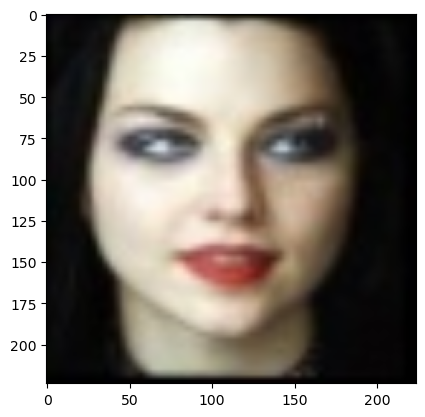

In [ ]:
imshow(image)

In [ ]:
from torchvision import models

# буду использовать resnet18
model = models.resnet18(pretrained=True)

# замораживаем все
for name, param in model.named_parameters():
    param.requires_grad = False
# размораживаем некоторые слои для обучения
for name, param in model.layer3.named_parameters():
    param.requires_grad = True
for name, param in model.layer4.named_parameters():
    param.requires_grad = True
for name, param in model.fc.named_parameters():
    param.requires_grad = True

# смотрим, что разморожено как планировалось
for name, param in model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

conv1.weight: requires_grad = False
bn1.weight: requires_grad = False
bn1.bias: requires_grad = False
layer1.0.conv1.weight: requires_grad = False
layer1.0.bn1.weight: requires_grad = False
layer1.0.bn1.bias: requires_grad = False
layer1.0.conv2.weight: requires_grad = False
layer1.0.bn2.weight: requires_grad = False
layer1.0.bn2.bias: requires_grad = False
layer1.1.conv1.weight: requires_grad = False
layer1.1.bn1.weight: requires_grad = False
layer1.1.bn1.bias: requires_grad = False
layer1.1.conv2.weight: requires_grad = False
layer1.1.bn2.weight: requires_grad = False
layer1.1.bn2.bias: requires_grad = False
layer2.0.conv1.weight: requires_grad = False
layer2.0.bn1.weight: requires_grad = False
layer2.0.bn1.bias: requires_grad = False
layer2.0.conv2.weight: requires_grad = False
layer2.0.bn2.weight: requires_grad = False
layer2.0.bn2.bias: requires_grad = False
layer2.0.downsample.0.weight: requires_grad = False
layer2.0.downsample.1.weight: requires_grad = False
layer2.0.downsample.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
from tqdm import tqdm, tqdm_notebook

# ниже функции для обучения, валидации и тестирования, адаптированные и под ArcFace и под CrossEntropy

# функция для обучения эпохи
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # написано так, потому что ArcFace определяется ниже и isinstance(criterion, ArcFaceLoss) выдаст ошибку
        if not isinstance(criterion, nn.CrossEntropyLoss):
            outputs = nn.functional.linear(outputs, criterion.weight)

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

# функция для валидации эпохи с сохранением модель у кот лучший val_loss
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if not isinstance(criterion, nn.CrossEntropyLoss):
                outputs = nn.functional.linear(outputs, criterion.weight)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    global best_val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        if not isinstance(criterion, nn.CrossEntropyLoss):
            torch.save(model.state_dict(), "best_classification_model_with_arc_face.pth")
        else:
            torch.save(model.state_dict(), "best_classification_model_with_cross_entropy.pth")

        print(f"Model saved with val loss {best_val_loss:.4f}")
    return val_loss, val_acc


from torch.optim.lr_scheduler import StepLR

# обучение модели
def train(train_loader, val_loader, model, opt, criterion, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    scheduler = StepLR(opt, step_size=2, gamma=0.5)

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step()

    return history

# функция для тестирования модели
def test_model(model, data_loader, criterion):
    model.eval()
    running_corrects = 0
    processed_size = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            if not isinstance(criterion, nn.CrossEntropyLoss):
                outputs = nn.functional.linear(outputs, criterion.weight)
            preds = torch.argmax(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    test_acc = running_corrects.double() / processed_size

    return test_acc

# функция для рисования лоса
def plotHistoryLoss(history):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
n_classes = 200
epochs = 10
model.fc = nn.Linear(512, n_classes)
model = model.to(device)
# считаем градиенты по всем незамороженным слоям
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()
best_val_loss = float('inf')

history = train(train_loader, val_loader, model=model, opt=opt, criterion=criterion, epochs=epochs, batch_size=batch_size)

epoch:  10%|███▌                                | 1/10 [02:19<20:53, 139.30s/it]

Model saved with val loss 3.4940

Epoch 001 train_loss: 4.4539     val_loss 3.4940 train_acc 0.1049 val_acc 0.2169


epoch:  20%|███████▏                            | 2/10 [04:38<18:35, 139.41s/it]

Model saved with val loss 2.4625

Epoch 002 train_loss: 2.7272     val_loss 2.4625 train_acc 0.3652 val_acc 0.4210


epoch:  30%|██████████▊                         | 3/10 [07:00<16:21, 140.28s/it]

Model saved with val loss 1.8402

Epoch 003 train_loss: 1.6129     val_loss 1.8402 train_acc 0.6397 val_acc 0.5607


epoch:  40%|██████████████▍                     | 4/10 [09:19<13:59, 139.84s/it]

Model saved with val loss 1.6970

Epoch 004 train_loss: 1.0914     val_loss 1.6970 train_acc 0.7677 val_acc 0.5974


epoch:  50%|██████████████████                  | 5/10 [11:38<11:38, 139.61s/it]

Model saved with val loss 1.3850

Epoch 005 train_loss: 0.6552     val_loss 1.3850 train_acc 0.8849 val_acc 0.6691


epoch:  60%|█████████████████████▌              | 6/10 [14:02<09:24, 141.13s/it]

Model saved with val loss 1.3066

Epoch 006 train_loss: 0.4426     val_loss 1.3066 train_acc 0.9376 val_acc 0.6912


epoch:  70%|█████████████████████████▏          | 7/10 [16:34<07:14, 144.69s/it]

Model saved with val loss 1.2038

Epoch 007 train_loss: 0.2834     val_loss 1.2038 train_acc 0.9710 val_acc 0.7096


epoch:  80%|████████████████████████████▊       | 8/10 [19:01<04:50, 145.48s/it]

Model saved with val loss 1.1790

Epoch 008 train_loss: 0.2260     val_loss 1.1790 train_acc 0.9824 val_acc 0.7224


epoch:  90%|████████████████████████████████▍   | 9/10 [21:28<02:25, 145.79s/it]

Model saved with val loss 1.1444

Epoch 009 train_loss: 0.1707     val_loss 1.1444 train_acc 0.9916 val_acc 0.7316


epoch: 100%|███████████████████████████████████| 10/10 [23:55<00:00, 143.51s/it]


Epoch 010 train_loss: 0.1485     val_loss 1.1528 train_acc 0.9935 val_acc 0.7188


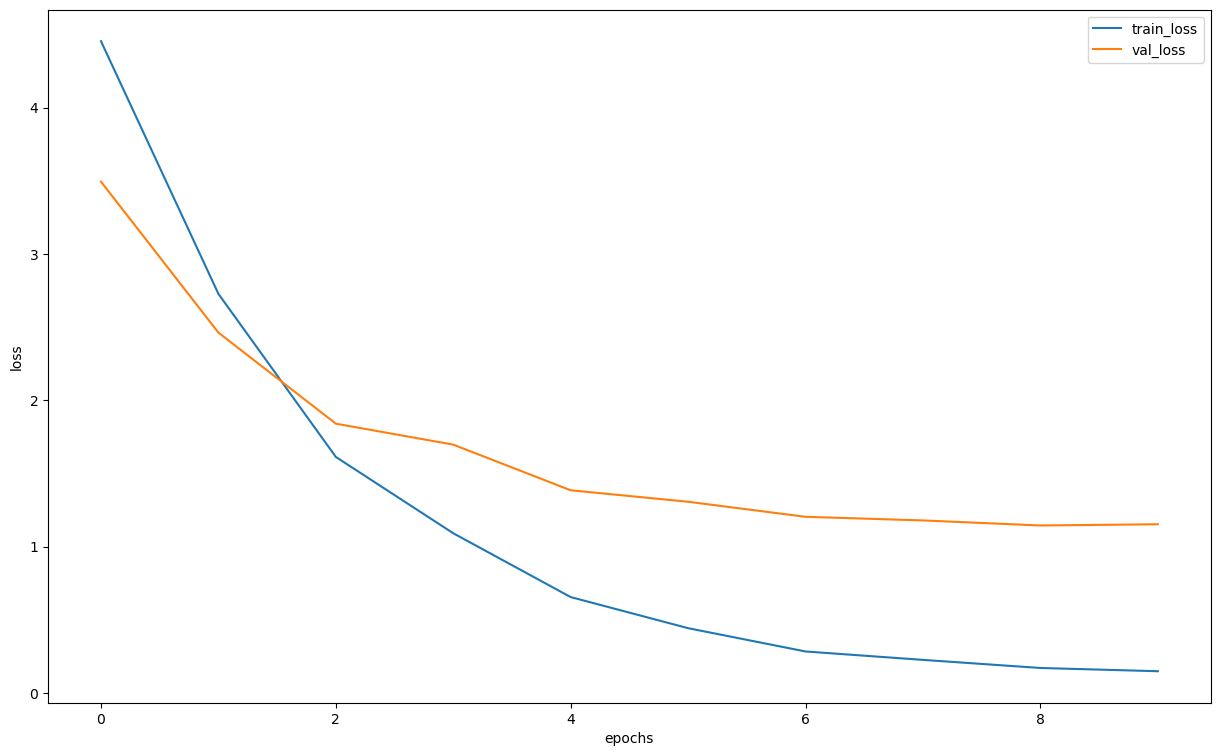

In [ ]:
plotHistoryLoss(history)

In [ ]:
# используя лучшую модель, посмотрим результаты на test
final_cross_entropy_model = models.resnet18(pretrained=True)
final_cross_entropy_model.fc = nn.Linear(512, n_classes)
final_cross_entropy_model = final_cross_entropy_model.to(device)
final_cross_entropy_model.load_state_dict(torch.load('best_classification_model_with_cross_entropy.pth'))
# final_cross_entropy_model.load_state_dict(torch.load('best_classification_model_with_cross_entropy.pth', map_location=torch.device('cpu')))
test_acc = test_model(final_cross_entropy_model, test_loader, criterion)
test_acc

tensor(0.7235, dtype=torch.float64)

для СrossEntropy готово!

In [ ]:
# реализация ArcFace Loss
import math

class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, device='cpu'):
        super().__init__()
        self.s = s
        self.m = m
        self.device = torch.device(device)
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features).to(self.device))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m


    def forward(self, embeddings, labels):
        embeddings = embeddings.to(self.device)
        labels = labels.to(self.device)
        # Нормализация весов и входных данных
        normed_weight = F.normalize(self.weight, dim=1)
        normed_embeddings = F.normalize(embeddings, dim=1)

        # Вычисляем cos(θ)
        cosine = F.linear(normed_embeddings, normed_weight)
        # Вычисляем sin(θ) = sqrt(1 - cos^2(θ))
        sine = torch.sqrt(1.0 - torch.clamp(cosine ** 2, 0, 1))
        # Добавляем угловую маржу
        phi = cosine * self.cos_m - sine * self.sin_m

        # Для стабильности
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        # Создаём one-hot вектор меток
        one_hot = torch.zeros_like(cosine).to(self.device)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        # Итоговая модифицированная логитная функция
        logits = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        logits *= self.s

        # Возвращаем Softmax Loss
        loss = F.cross_entropy(logits, labels)
        return loss

In [ ]:
# модель для ArcFace
model2 = models.resnet18(pretrained=True)
# убираем последний слой
model2.fc = nn.Identity()

In [ ]:
# замороживаем по аналогии с моделью для CrossEntropy
for name, param in model2.named_parameters():
    param.requires_grad = False
for name, param in model2.layer3.named_parameters():
    param.requires_grad = True
for name, param in model2.layer4.named_parameters():
    param.requires_grad = True

for name, param in model2.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

conv1.weight: requires_grad = False
bn1.weight: requires_grad = False
bn1.bias: requires_grad = False
layer1.0.conv1.weight: requires_grad = False
layer1.0.bn1.weight: requires_grad = False
layer1.0.bn1.bias: requires_grad = False
layer1.0.conv2.weight: requires_grad = False
layer1.0.bn2.weight: requires_grad = False
layer1.0.bn2.bias: requires_grad = False
layer1.1.conv1.weight: requires_grad = False
layer1.1.bn1.weight: requires_grad = False
layer1.1.bn1.bias: requires_grad = False
layer1.1.conv2.weight: requires_grad = False
layer1.1.bn2.weight: requires_grad = False
layer1.1.bn2.bias: requires_grad = False
layer2.0.conv1.weight: requires_grad = False
layer2.0.bn1.weight: requires_grad = False
layer2.0.bn1.bias: requires_grad = False
layer2.0.conv2.weight: requires_grad = False
layer2.0.bn2.weight: requires_grad = False
layer2.0.bn2.bias: requires_grad = False
layer2.0.downsample.0.weight: requires_grad = False
layer2.0.downsample.1.weight: requires_grad = False
layer2.0.downsample.

In [ ]:
from tqdm import tqdm, tqdm_notebook

batch_size = 64
epochs = 10
model2 = model2.to(device)
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001)
# при s=50, m=0.45 результаты получились лучше, чем при кроссэнтропии
criterion = ArcFaceLoss(in_features=512, out_features=n_classes, s=50, m=0.45, device=device)
best_val_loss = float('inf')
history2 = train(train_loader, val_loader, model=model2, opt=opt, criterion=criterion, epochs=epochs, batch_size=batch_size)

epoch:  10%|███▌                                | 1/10 [02:19<20:55, 139.46s/it]

Model saved with val loss 25.6567

Epoch 001 train_loss: 26.9024     val_loss 25.6567 train_acc 0.1112 val_acc 0.1857


epoch:  20%|███████▏                            | 2/10 [04:40<18:42, 140.28s/it]

Model saved with val loss 24.8060

Epoch 002 train_loss: 24.3174     val_loss 24.8060 train_acc 0.3820 val_acc 0.3088


epoch:  30%|██████████▊                         | 3/10 [07:00<16:22, 140.36s/it]

Model saved with val loss 21.8104

Epoch 003 train_loss: 21.5025     val_loss 21.8104 train_acc 0.6256 val_acc 0.5239


epoch:  40%|██████████████▍                     | 4/10 [09:22<14:04, 140.78s/it]

Model saved with val loss 19.7458

Epoch 004 train_loss: 18.7766     val_loss 19.7458 train_acc 0.7362 val_acc 0.5956


epoch:  50%|██████████████████                  | 5/10 [11:43<11:44, 140.99s/it]

Model saved with val loss 17.3634

Epoch 005 train_loss: 15.2151     val_loss 17.3634 train_acc 0.8372 val_acc 0.6507


epoch:  60%|█████████████████████▌              | 6/10 [14:03<09:22, 140.59s/it]

Model saved with val loss 16.0754

Epoch 006 train_loss: 12.6534     val_loss 16.0754 train_acc 0.8818 val_acc 0.6893


epoch:  70%|█████████████████████████▏          | 7/10 [16:22<07:00, 140.26s/it]

Model saved with val loss 14.8757

Epoch 007 train_loss: 10.3230     val_loss 14.8757 train_acc 0.9276 val_acc 0.7151


epoch:  80%|████████████████████████████▊       | 8/10 [18:42<04:39, 139.96s/it]

Model saved with val loss 14.0966

Epoch 008 train_loss: 8.8283     val_loss 14.0966 train_acc 0.9399 val_acc 0.7371


epoch:  90%|████████████████████████████████▍   | 9/10 [21:03<02:20, 140.50s/it]

Model saved with val loss 13.5112

Epoch 009 train_loss: 7.5827     val_loss 13.5112 train_acc 0.9566 val_acc 0.7555


epoch: 100%|███████████████████████████████████| 10/10 [23:27<00:00, 140.75s/it]

Model saved with val loss 13.2648

Epoch 010 train_loss: 6.9429     val_loss 13.2648 train_acc 0.9642 val_acc 0.7463


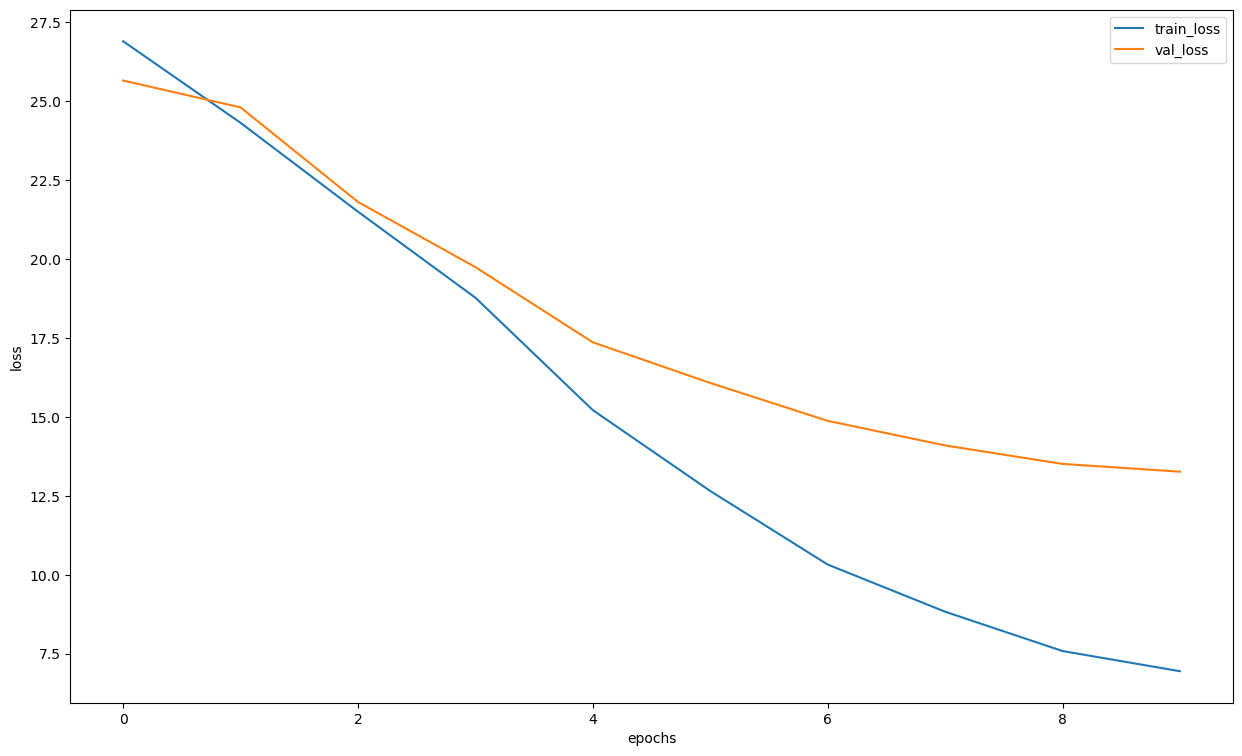

In [ ]:
plotHistoryLoss(history2)

In [ ]:
# проверяем какое accuracy на лучшей моделе
final_arc_face_model = models.resnet18(pretrained=True)
final_arc_face_model.fc = nn.Identity()
final_arc_face_model = final_arc_face_model.to(device)
final_arc_face_model.load_state_dict(torch.load('best_classification_model_with_arc_face.pth'))
test_acc = test_model(final_arc_face_model, test_loader, criterion)
test_acc.item()

0.7301324503311258

Для ArcFace получилось чуть лучше. Наверняка можно сделать еще лучше, если подобрать гиперпараметры